In [24]:
import torch
import torchvision as tv
from PIL import Image
import numpy as np

In [2]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [3]:
# Check for device

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if (device == 'cuda'):
    print('GPU is available')
    
else:
    print('Running on CPU. Be very patient')

Running on CPU. Be very patient


In [ ]:
# Import the model
vgg = tv.models.vgg19(pretrained=True)

for param in vgg.parameters():
    param.requires_grad = False

# Transfer to the device
vgg.to(device)

In [10]:
# Function for loading the images

def image_loader(path,max_size =512,shape = None):
    if('http' in path):
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
    else:
        img = Image.open(path).convert('RGB')
        
    if(max(img.size)>max_size):
        size = max_size
        
    else:
        size = img.size
    
    if shape is not None:
        size = shape
        
    
    im_transform = tv.transforms.Compose([tv.transforms.Resize(size),
                                          tv.transforms.ToTensor(),
                                          tv.transforms.Normalize((0.485, 0.456, 0.406), 
                                                                  (0.229, 0.224, 0.225))])
        
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    img = im_transform(img)[:3,:,:].unsqueeze(0)
    
    return img

In [16]:
content_image = image_loader('jobs.jpg').to(device)
style_image = image_loader('sty1.jpg',shape = content_image.shape[-2:]).to(device)

In [17]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

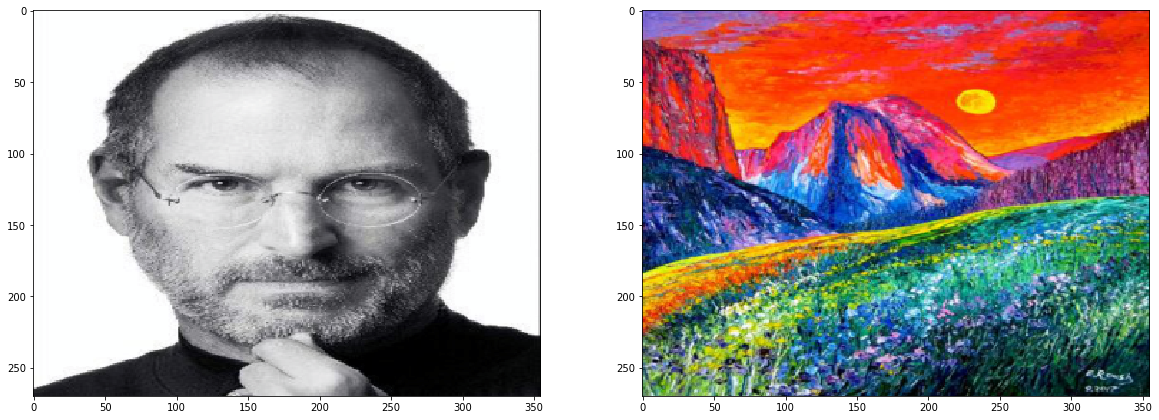

In [26]:
#display the pics

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))

In [27]:
def get_features(model,layers,image):
    
    features = {}
    
    x = image
    for name, layer in model._modules.item():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features
    

The style loss is calculated as the squared difference between the **gram matrixes** of the target and style image at the desired layers. 

In [28]:
def gram_matrix(tensor):
    _,d,h,w = tensor.shape
    matrix1 = tensor.view(d,h*w)
    matrix2 = matrix1.t()
    gram = torch.mm(matrix1,matrix2)
    return gram

In [33]:
# Define the layers to fetch the features and content from:

# This is specific to VGG19

layers = {'0': 'conv1_1',
          '5': 'conv2_1',                 
          '10': 'conv3_1',                 
          '19': 'conv4_1',                 
          '21': 'conv4_2',  ## content representation                 
          '28': 'conv5_1'
         }

In [ ]:
style_features = get_features(vgg,layers,style_image)
content_features = get_features(vgg,layers,content_image)

In [ ]:
style_grams = {layer: gram_matrix(layer) for layer in style_features}

target = content_image.clone().requires_grad(True).to(device)

In [34]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [35]:
# define the optimizer
optimizer = torch.optim.Adam([target])

NameError: name 'target' is not defined

In [ ]:
epoch = 5000
print_every = 500

for i in range(1,epoch+1):
    optimizer.zero_grad()
    target_features = get_features(vgg,layers,target)
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    
    style_loss =0
    for layer in style_features:
        temp_target_feature = target_features[layer]
        target_gram = gram_matrix(temp_target_feature)
        _,d,h,w = temp_target_feature
        
        style_loss += style_weights[layer] * torch.mean(target_gram - style_grams[layer]**2) / (d*h*w)
        
    loss = content_weight * content_loss + style_weight * style_loss
    
    loss.backward()
    
    optimizer.step()
    
    if (i%print_every ==0):
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))